In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pls
import seaborn as sns

from scipy import stats

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Задания

Вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.


2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.


3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

****

*ссылки на файлы:*

- [reg_data](https://drive.google.com/file/d/1NuSSdBwVrMDTlpRR08vC5jcUA_4ByQB8/view?usp=sharing)
- [auth_data](https://drive.google.com/file/d/1B0_M56msDXbGZo3DOrjg5uTU0KQ7Zb5r/view?usp=sharing)
- [A/B test](https://drive.google.com/file/d/134eD9tG0OR_qwtyMHcwAUmrLV5DZmLM0/view?usp=sharing)

# TASK 1 — Напишите функцию для подсчета retention

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).


Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

##### Импортируем данные

In [2]:
# данные о времени регистрации
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-baranov/shared/problem1-reg_data.csv', sep=';')

# данные о времени захода пользователей в игру
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-baranov/shared/problem1-auth_data.csv', sep=';')

## 1. Предварительное исследование данных

### 1.1. Исследуем данные о времени регистрации

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.shape

(1000000, 2)

In [5]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
# кол-во уникальных значений в reg_ts
reg_data.reg_ts.nunique()

1000000

In [7]:
# кол-во уникальных значений в uid
reg_data.uid.nunique()

1000000

#### Преобразуем время из UNIX в human-readable формат

Перезапишем данные для исследования, т. к. тестировать функцию мы должны на исходных данных

In [8]:
reg_data_research = reg_data[['reg_ts', 'uid']]

In [9]:
reg_data_research['reg_time'] = pd.to_datetime(reg_data_research.reg_ts, unit='s')

In [10]:
reg_data_research.reg_time.min()

Timestamp('1998-11-18 09:43:43')

In [11]:
reg_data_research.reg_time.max()

Timestamp('2020-09-23 15:17:24')

#### Посмотрим на распределение данных по году

In [12]:
reg_data_research.reg_time.dt.year.value_counts().to_frame()

,reg_time
2020,354963
2019,291102
2018,159729
2017,87645
2016,48187
2015,26344
2014,14455
2013,7932
2012,4361
2011,2385


*__Вывод:__* в датасете представлены данные о регистрации в мобильном приложении с 1998 по 2020 г.. Сам факт регистрации в мобильном приложении в 1998 году звучит немыслимо, скорее всего с данными что-то не так (или это просто сугубо тренировочный датасет).

### 1.2. Исследуем данные о времени захода пользователей в игру

In [13]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [14]:
auth_data.shape

(9601013, 2)

In [15]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [16]:
# кол-во уникальных значений в auth_ts
auth_data.auth_ts.nunique()

9180915

In [17]:
# кол-во уникальных значений в uid
auth_data.uid.nunique()

1000000

*__Вывод:__* Кол-во уникальных id сходится с данными о регистрации

#### Преобразуем время из UNIX в human-readable формат

Перезапишем данные для исследования, т. к. тестировать функцию мы должны на исходных данных

In [18]:
auth_data_research = auth_data[['auth_ts', 'uid']]

In [19]:
auth_data_research['auth_time'] = pd.to_datetime(auth_data_research.auth_ts, unit='s')

In [20]:
auth_data_research.auth_time.min()

Timestamp('1998-11-18 09:43:43')

In [21]:
auth_data_research.auth_time.max()

Timestamp('2020-09-23 15:17:24')

#### Посмотрим на распределение данных по году

In [22]:
auth_data_research.auth_time.dt.year.value_counts().to_frame()

,auth_time
2020,3417477
2019,2799674
2018,1535896
2017,844220
2016,457862
2015,254184
2014,136683
2013,72555
2012,39736
2011,20332


### Вывод:

В датасетах представленны данные о взаимодействии пользователей с мобильным приложением с 1998 по 2020 г.. Это слишком большой период для подсчета дневного retention, поэтому для тестирования буду использовать небольшие **выборки**.

****

**Что должна делать функция:**

1. Считать дневной retention


2. Возвращать график и датафрейм (для визуализации в BI-системах)
    
    2.1. Предоставлять возможность возвращать только датафрейм


3. Считать retention в указанном диапазоне дат


4. Принимать на вход пути до файлов и/или датафреймы


5. Импортировать все необходимые библиотеки

## 2. Напишем функцию для подсчёта retention игроков 
_**по дням** от даты регистрации игрока_

In [23]:
def get_retention(
    reg_data,
    auth_data,
    start_date,
    finish_date,
    visual = True
):
    '''
    Function for calculating retention in a mobile game
    
    Args:
        reg_data: str(path_to_file) or pandas.DataFrame
        auth_data: str(path_to_file) or pandas.DataFrame
        start_date: list [yyyy, m, d]
        start_date: list [yyyy, m, d]
        visual: bool
        
    Returns:
        if visual = True:
            seaborn.heatmap(pandas.DataFrame, annot=True, fmt='.0%')
        {'data_frame': retention_df}
        
    For example:
        start_list = [2019, 12, 31]
        finish_list = [2020, 1, 8]
        retention_with_path = get_retention(reg_data_path, auth_data_path, start_list, finish_list)
        retention_with_DataFrame = get_retention(reg_data_df, auth_data_df, start_list, finish_list)
        retention_without visualization = get_retention(reg_data, auth_data, start_list, finish_list, visual=False)
    '''
    
    # Импортируем нужные библиотеки
    import pandas as pd
    import numpy as np
    import datetime
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    import warnings
    warnings.filterwarnings('ignore')
    
    # Читаем данные
    def read_my_file(path_to_file):
        try:
            my_data = pd.read_csv(path_to_file, sep=';')
            return my_data
        
        except FileNotFoundError:
            pass
    
    # данные о времени регистрации пользователей
    try:
        reg_data = read_my_file(reg_data)
        
    except ValueError:
        pass
    
    # данные о времени захода пользователей в игру
    try:
        auth_data = read_my_file(auth_data)
    
    except ValueError:
        pass
        
    # Приведём дату в формат "год-месяц-день"
    reg_data['reg_time'] = pd.to_datetime(reg_data.reg_ts, unit='s')
    reg_data['reg_time'] = reg_data.reg_time.dt.date
    auth_data['auth_time'] = pd.to_datetime(auth_data.auth_ts, unit='s')
    auth_data['auth_time'] = auth_data.auth_time.dt.date
    
    # Зададим временной период для подсчета retention
    start = datetime.date(start_date[0], start_date[1], start_date[2])
    finish = datetime.date(finish_date[0], finish_date[1], finish_date[2])

    reg_data = reg_data.query('reg_time >= @start and reg_time <= @finish')
    auth_data = auth_data.query('auth_time >= @start and auth_time <= @finish')
    
    # Объединим auth_data с reg_data_sample по uid
    reg_auth_merged = auth_data.merge(reg_data, how='inner', on='uid')

    # Сделаем когорты
    cohorts = reg_auth_merged.groupby(['reg_time', 'auth_time']) \
        .agg({'uid': 'nunique'})

    # Функция для подсчета номера дня от даты регистрации
    def num_of_day(df):
        df['day'] = np.arange(len(df))
        return df

    # Применяем функцию
    cohorts = cohorts.groupby('reg_time').apply(num_of_day)

    # Добавим колонку day в индекс
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['day','reg_time'], inplace=True)

    # Создадим датафрейм с общим кол-вом зарегистрированных пользователей по датам
    cohort_group_size = reg_data.groupby('reg_time').agg({"uid": "nunique"}).uid

    # Посчитаем retention
    retention_df = cohorts['uid'].unstack('day').div(cohort_group_size, axis=0)
    
    # Если False, то визуализации не будет
    if visual == True:
    
        # Изменим dtype индекса с datetime64[ns] на str для удобства визуализации
        df_viz = retention_df.iloc[0:-1]
        df_viz.reset_index(inplace=True)
        df_viz['reg_time'] = df_viz['reg_time'].dt.strftime('%m/%d/%Y')
        df_viz.set_index(['reg_time'], inplace=True)

        # Визуализируем
        sns.set(style='white')
        plt.figure(figsize=(15, 5))
        plt.title('Retention')
        sns.heatmap(df_viz, annot=True, fmt='.0%')
        
    else:
        pass
    
    return {'data_frame': retention_df}

**Документация**

In [24]:
help(get_retention)

Help on function get_retention in module __main__:

get_retention(reg_data, auth_data, start_date, finish_date, visual=True)
    Function for calculating retention in a mobile game
    
    Args:
        reg_data: str(path_to_file) or pandas.DataFrame
        auth_data: str(path_to_file) or pandas.DataFrame
        start_date: list [yyyy, m, d]
        start_date: list [yyyy, m, d]
        visual: bool
        
    Returns:
        if visual = True:
            seaborn.heatmap(pandas.DataFrame, annot=True, fmt='.0%')
        {'data_frame': retention_df}
        
    For example:
        start_list = [2019, 12, 31]
        finish_list = [2020, 1, 8]
        retention_with_path = get_retention(reg_data_path, auth_data_path, start_list, finish_list)
        retention_with_DataFrame = get_retention(reg_data_df, auth_data_df, start_list, finish_list)
        retention_without visualization = get_retention(reg_data, auth_data, start_list, finish_list, visual=False)



## 3. Протестируем функцию 

### 3.1. Укажем путь до файла

In [25]:
reg_data_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-baranov/shared/problem1-reg_data.csv'
auth_data_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-baranov/shared/problem1-auth_data.csv'
start = [2019, 10, 10]
finish = [2019, 10, 17]

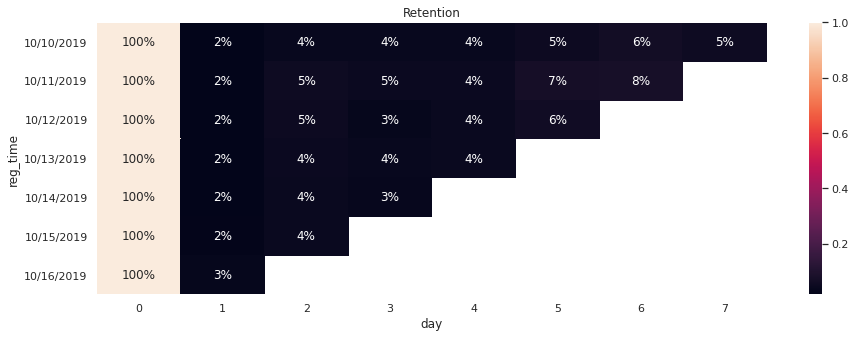

In [26]:
retention_path = get_retention(reg_data_path, auth_data_path, start, finish)

In [27]:
retention_path['data_frame']

day,0,1,2,3,4,5,6,7
reg_time,,,,,,,,
2019-10-10,1.0,0.016199,0.035637,0.036717,0.037797,0.050756,0.063715,0.051836
2019-10-11,1.0,0.018319,0.052802,0.045259,0.044181,0.071121,0.075431,NaN
2019-10-12,1.0,0.017223,0.050592,0.031216,0.043057,0.060280,NaN,NaN
2019-10-13,1.0,0.019334,0.044039,0.036520,0.042965,NaN,NaN,NaN
2019-10-14,1.0,0.018240,0.039700,0.033262,NaN,NaN,NaN,NaN
2019-10-15,1.0,0.022484,0.042827,NaN,NaN,NaN,NaN,NaN
2019-10-16,1.0,0.027807,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-17,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2. Укажем датафрейм

In [28]:
start = [2015, 1, 1]
finish = [2015, 1, 14]

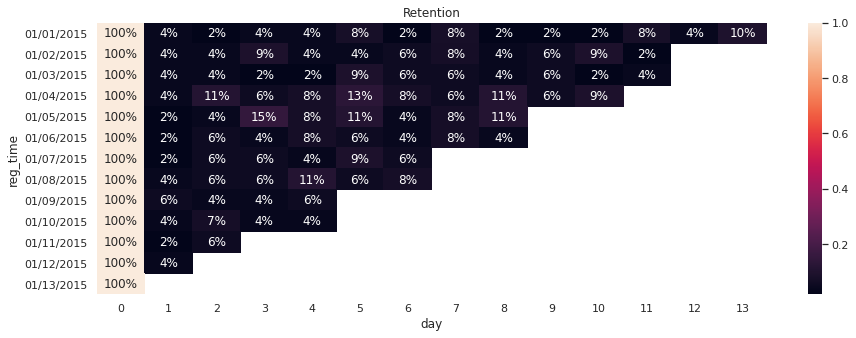

In [29]:
retention_df = get_retention(reg_data, auth_data, start, finish)

In [30]:
retention_df['data_frame']

day,0,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_time,,,,,,,,,,,,,,
2015-01-01,1.0,0.038462,0.019231,0.038462,0.038462,0.076923,0.019231,0.076923,0.019231,0.019231,0.019231,0.076923,0.038462,0.096154
2015-01-02,1.0,0.037736,0.037736,0.094340,0.037736,0.037736,0.056604,0.075472,0.037736,0.056604,0.094340,0.018868,NaN,NaN
2015-01-03,1.0,0.037736,0.037736,0.018868,0.018868,0.094340,0.056604,0.056604,0.037736,0.056604,0.018868,0.037736,NaN,NaN
2015-01-04,1.0,0.037736,0.113208,0.056604,0.075472,0.132075,0.075472,0.056604,0.113208,0.056604,0.094340,NaN,NaN,NaN
2015-01-05,1.0,0.018868,0.037736,0.150943,0.075472,0.113208,0.037736,0.075472,0.113208,NaN,NaN,NaN,NaN,NaN
2015-01-06,1.0,0.018868,0.056604,0.037736,0.075472,0.056604,0.037736,0.075472,0.037736,NaN,NaN,NaN,NaN,NaN
2015-01-07,1.0,0.018519,0.055556,0.055556,0.037037,0.092593,0.055556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,1.0,0.037736,0.056604,0.056604,0.113208,0.056604,0.075472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,1.0,0.056604,0.037736,0.037736,0.056604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.3. Без визуализации

In [31]:
start = [2020, 9, 15]
finish = [2020, 9, 23]

In [32]:
retention_no_visual = get_retention(reg_data, auth_data, start, finish, visual=False)

In [33]:
retention_no_visual['data_frame']

day,0,1,2,3,4,5,6,7,8
reg_time,,,,,,,,,
2020-09-15,1.0,0.022181,0.040665,0.045595,0.060382,0.056069,0.069008,0.056685,0.024646
2020-09-16,1.0,0.019077,0.042462,0.046154,0.046769,0.067692,0.069538,0.033846,NaN
2020-09-17,1.0,0.016585,0.042998,0.045455,0.054668,0.062654,0.042383,NaN,NaN
2020-09-18,1.0,0.019018,0.045399,0.042331,0.052147,0.037423,NaN,NaN,NaN
2020-09-19,1.0,0.018360,0.035496,0.047124,0.034884,NaN,NaN,NaN,NaN
2020-09-20,1.0,0.024450,0.043399,0.023839,NaN,NaN,NaN,NaN,NaN
2020-09-21,1.0,0.018926,0.029915,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-22,1.0,0.008531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-23,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Итог

- Функция `get_retention` способна посчитать дневной retention в указанном диапазоне дат. Даты подаются на вход в виде списка [год, месяц, день]. Например: `start_date = [2020, 1, 31]`.


- Для удобства на вход функция способна принять как датафрейм, так и путь файла. 


- На выход функция даёт визуализацию retention и словарь с 1 парой ключ-значение, где хранится датафрейм с рассчитанным retention. 


- По желанию визуализацию можно не выводить, для этого в аргументах нужно указать: `visual = True`. Это реализовано специально для удобства работы с BI-системами.

# TASK  2 — A/B тест

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.


Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [34]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep=';')

In [35]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


##### Разобьём датафрейм по группам

In [36]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

## 1. Предварительное исследование данных

In [37]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [38]:
df.shape

(404770, 3)

In [39]:
# Кол-во пустых значений
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [40]:
# Кол-во уникальных пользователей 
df.user_id.nunique()

404770

In [41]:
# Кол-во уникальных значений revenue
df.revenue.nunique()

1477

#### Сколько всего денег заработали с каждой группы

In [42]:
df.groupby('testgroup').agg({'revenue': 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


Тестовая группа принесла денег больше контрольной на 285 тыс.

#### Конверсия в покупку для каждой группы

In [43]:
df_all = df.groupby('testgroup').agg({'user_id': 'count'}).rename(columns={'user_id': 'all_users'})
df_buyers = df.query('revenue > 0').groupby('testgroup').agg({'user_id': 'count'}).rename(columns={'user_id': 'buyers'})
df_conversion = df_all.merge(df_buyers, on='testgroup')
df_conversion['conversion'] = df_conversion.buyers / df_conversion.all_users
df_conversion

,all_users,buyers,conversion
testgroup,,,
a,202103,1928,0.009540
b,202667,1805,0.008906


Конверсия у группы **a** - 0.95%

Конверсия у группы **b** - 0.89%

_**Вывод:**_ 

- Конверсия у группы **a** выше 


- Больше денег принесла группа **b**

Углубимся в данные и посмотрим на их распределение.

#### Описательная статистика

In [44]:
df.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


_Из описательной статистики можем увидеть, что:_

- Среднее revenue (ARPU) в группе **b** чуть больше, чем в группе **a** _(отличаются на 5.26%)_


- Стандартное отклонение (std) у группы **a** примерно в 3.2 раза больше, чем у группы **b**


- Абсолютно большая часть пользователей не сконвертировались в покупателей


- Максимальное значение в группе **a** примерно в 9.3 раз больше, чем у группы **b** _(возможно, это из-за выбросов)_

#### Посмотрим на платящих пользователей

In [45]:
df.query('revenue > 0').groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


_Из описательной статистики можем увидеть, что:_

- Среднее revenue на платящего пользователя (ARPPU) в группе **b** больше, чем в группе **a** _(отличаются примерно на 12.75%)_


- Стандартное отклонение (std) у группы **a** примерно в 15 раз больше, чем у группы **b**


- Минимальное значение у группы **b** в 10 раз больше, чем у группы **a**


- Максимальное значение у группы **a** примерно в 9 раз больше, чем у группы **b**


- 25, 50 и 75 перцентили у группы **b** примерно в 10 раз больше, чем у группы **a**

#### Посмотрим на визуальное распределение платящих пользователей

*1. Гистограммы*

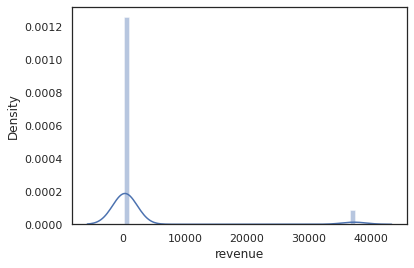

In [46]:
# группа a
sns.distplot(df_a.query('revenue > 0').revenue)

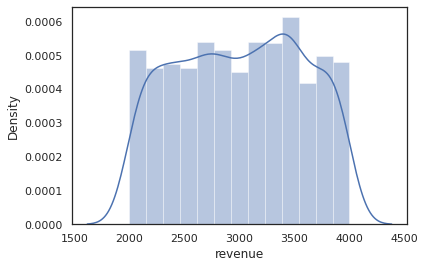

In [47]:
# группа b
sns.distplot(df_b.query('revenue > 0').revenue)

*2. Боксплоты*

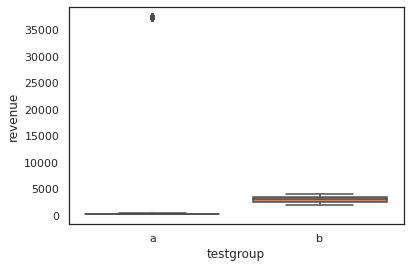

In [48]:
sns.boxplot(data=df.query('revenue > 0'), x='testgroup', y='revenue')

### Вывод:

Различия между контрольной и тестовой группами слишком ярко выражены. Я предполагаю, что **система сплитования сломана**, т. к. в основном в группе **a** представлены наименее доходные и самые высокодоходные пользователи, а в группе **b** - просто высокодоходные. 

Вряд ли с помощью новых акционных наборов можно так сильно уравнять величину покупок платящих пользователей и было бы крайне не логично урезать покупательскую способность самых высокодоходных покупателей.

Исходя из этого, проводить дальнейший анализ и определять _"какой набор предложений можно считать лучшим"_ нецелесообразно, т. к. наши выборки нерепрезентативны. Нужно исправлять сплитование и **заново проводить A/B тест**.

Но при этом можно провести анализ с целью ответа на вопрос: _"какие метрики стоит проанализировать для принятия правильного решения и как?"_.

## 2. Статистический анализ

В качестве метрик для анализа я выбрал:

- **ARPU** _(Average revenue per user)_ - средний доход с пользователя


- **ARPPU** _(Average revenue per paying user)_ - средний доход с платящего пользователя


- **CR** _(Conversion Rate)_ - коэффициент конверсии пользователя в покупателя

### 2.1. ARPU

#### Подготовим выборки для тестирования ARPU

In [49]:
# Из каждой группы возьмём значения revenue
ARPU_a = df_a.revenue
ARPU_b = df_b.revenue

#### Проверим нормальность распределения с помощью теста Шапиро-Уилка

- *H0* - выборка изъята из ГС, где распределение признака соответствует нормальному


- *H1* - распределение отклоняется от нормального

In [50]:
stats.shapiro(ARPU_a)

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [51]:
stats.shapiro(ARPU_b)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

Поскольку в обоих выборках p-value < 0.05, то мы отколняем нулевую гипотезу и принимаем альтернативную

#### Проверим гомогенность дисперсий с помощью критерия Левена

- *H0* - выборки имеют равные дисперсии


- *H1* - выборки не имеют равные дисперсии

In [52]:
stats.levene(ARPU_a, ARPU_b)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Так как p-value > 0.05, у нас нет оснований отклонить нулевую гипотезу

#### Проверим кол-во дубликатов

In [53]:
print(f'Кол-во дубликатов в группе a: {ARPU_a.duplicated().sum()}\n\
Кол-во дубликатов в группе b: {ARPU_b.duplicated().sum()}')

Кол-во дубликатов в группе a: 201834
Кол-во дубликатов в группе b: 201458


**С помощью чего будем проводить тестирование?**

Тест Шапиро-Уилка показал, что распределения наших выборок отклоняются от нормального. При этом требование гомогенности дисперсий удовлетворено.

Т. к. наши выборки достаточно велики, мы могли бы применить т-тест, но наличие сильных выбросов в контрольной группе могут исказить результаты. Рассмотрим непараметрический аналог - U-критерий Манна-Уитни.

Применить U-критерий будет неправильно, т. к. для его использования в выборочных данных не должно быть совпадающих значений (дубликатов) или таких совпадений должно быть очень мало (до 10). В нашем случае - большинство пользователей не совершили покупок, поэтому совпадающих значений будет слишком много.

Исходя из этого, я решил использовать **бутстрап** для сравнения выборочных средних.

In [54]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')

# функция для подсчета boorstrap с графиком и p-value
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок, которое будем считать
    statistic = np.mean, # интересующая нас статистика (среднее, медиана, ...)
    bootstrap_conf_level = 0.95 # уровень значимости, на базе которого будем проверять гипотезы
):
    boot_len = max([len(data_column_1), len(data_column_2)]) # берем максимальный размер выборки по каждому распределению
    boot_data = [] # пустой список, куда будем складывать все оценки по bootstrap
    
    # далее будем делать bootstrap под выборки
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    # считаем доверительные интервалы  
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    # считаем p-value по нормальному распределению
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

#### Применяем бутстрап средних

- *H0* - средние значения групп равны


- *H1* - средние значения групп не равны

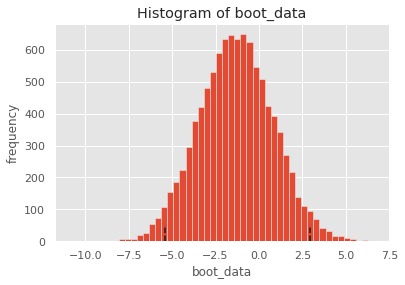

In [55]:
ARPU_boot = get_bootstrap(ARPU_a, ARPU_b)

In [56]:
ARPU_boot['p_value']

0.535146130679521

In [57]:
ARPU_boot['ci']

,0
0.025,-5.420624
0.975,2.911444


**_Вывод:_** бутстрап показал, что значимых различий по ARPU между контрольной и тестовой группами нет.

### 2.2. ARPPU

#### Подготовим выборки для тестирования ARPPU

In [58]:
# Из каждой группы возьмём значения, где revenue > 0
ARPPU_a = df_a.query('revenue > 0').revenue
ARPPU_b = df_b.query('revenue > 0').revenue

#### Проверим нормальность распределения с помощью теста Шапиро-Уилка

In [59]:
stats.shapiro(ARPPU_a)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [60]:
stats.shapiro(ARPPU_b)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

Поскольку в обоих выборках p-value < 0.05, то мы отколняем нулевую гипотезу и принимаем альтернативную

#### Проверим гомогенность дисперсий с помощью критерия Левена

In [61]:
stats.levene(ARPPU_a, ARPPU_b)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Так как p-value < 0.05, то принимаем альтернативную гипотезу

#### Проверим кол-во дубликатов

In [62]:
print(f'Кол-во дубликатов в группе a: {ARPPU_a.duplicated().sum()}\n\
Кол-во дубликатов в группе b: {ARPPU_b.duplicated().sum()}')

Кол-во дубликатов в группе a: 1660
Кол-во дубликатов в группе b: 597


**С помощью чего будем проводить тестирование?**

Тест Шапиро-Уилка показал, что распределения наших выборок отклоняются от нормального. Кроме этого, требование гомогенности дисперсий не удовлетворено.

В данном случае применять т-тест будет нецелесообразно.

U-критерий мы так же не можем применить из-за большого кол-ва дубликатов.

Исходя из этого, я решил снова использовать **бутстрап** средних.

#### Применяем бутстрап средних

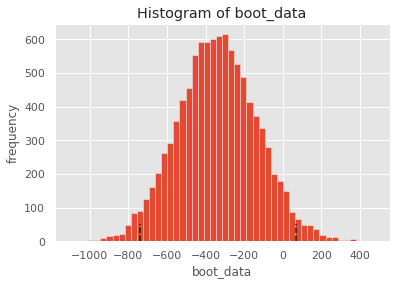

In [63]:
ARPPU_boot = get_bootstrap(ARPPU_a, ARPPU_b)

In [64]:
ARPPU_boot['p_value']

0.09833100215557876

In [65]:
ARPPU_boot['ci']

,0
0.025,-738.512915
0.975,69.689225


**_Вывод:_** т. к. p-value > 0.05, у нас нет оснований отклонить нулевую гипотезу, а следовательно, значимых отличий по ARPPU между контрольной и тестовой группами нет. 

### 2.3. CR

Т. к. Conversion Rate - это категориальная метрика, то для её проверки будем использовать **критерий Хи-квадрат**.

#### Для начала нужно составить таблицу сопряженности

In [66]:
# Перезапишем исходный датафрейм
df_chi = df[['user_id', 'revenue', 'testgroup']]

# Создадим столбец с категориальной переменной для конверсии
df_chi['conversion'] = df_chi['revenue'].apply(lambda x: x if x == 0 else 1 )

# Создадим таблицу сопряженности
contingency_table = pd.crosstab(df_chi.testgroup, df_chi.conversion).T

contingency_table

testgroup,a,b
conversion,,
0,200175,200862
1,1928,1805


#### Применим критерий Хи-квадрат

- *H0* - новые наборы акционных предложений (группа b) не оказывают влияние на Conversion Rate


- *H1* - новые наборы акционных предложений (группа b) оказывают влияние на Conversion Rate

In [67]:
stats.chi2_contingency(contingency_table[['a', 'b']])[1]

0.03647561892312613

**_Вывод:_** т. к. p-value < 0.05, то принимаем альтернативную гипотезу о том, что новые наборы акционных предложений оказывают влияние на Conversion Rate. В нашем случае — в отрицательную сторону, т. к. конверсия у группы b ниже.

## Итог

Как было написано ранее, я предполагаю, что система сплитования неисправна и наши выборки нерепрезентативны, а соответственно необходимо фиксить сплитование и проводить A/B тест заново. Ниже отвечу на поставленные вопросы.

1. _Какой набор предложений можно считать лучшим?_ — **на данный момент мы не можем сделать никаких выводов, поэтому оставляем контрольный набор и проводим тест заново.**


2. _Какие метрики стоит проанализировать для принятия правильного решения и как?_ — **ARPU, ARPPU, CR. Пример анализа приведен выше.**



# TASK  3 — Предложите метрики для оценки результатов ивента в игре

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


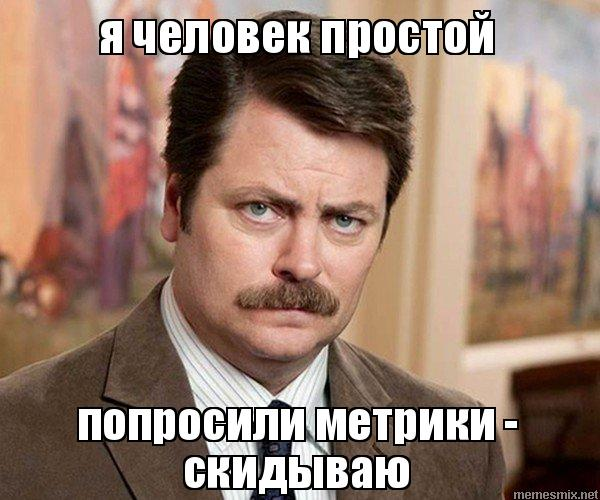

## 1. Для чего именно нам нужны метрики?

Для начала необходимо определить: **"Для чего мы вообще будем проводить тематические события в игре?"**

Мы проводим различные ивенты в первую очередь для вовлечения и удержания пользователей в нашем продукте. В самом ивенте для игрока главной целью является получение награды, а для этого ему нужно пройти как можно больше уровней за определенное время.

_Дополнение:_ если это праздник, например, Новый Год/Рождество, Хэллоуин и т. д., то дополнительной целью внутриигровых событий может являться — заряд праздничным настроением **:)**

## 2. Основные метрики

Мы определили для чего нам нужны внутриигровые события, а теперь на основании этого можем составить список основных метрик:

***

1. **MAU** (Monthly Active Users) - количество уникальных пользователей за месяц без учета повторных сессий.

_Пояснение:_ хотя данная метрика будет плохо отражать результаты ивентов, но она может показать общую ситуацию в нашем продукте. Если какая-то составляющая часть нашей игры (в том числе и ивенты) не будет нравиться нашим пользователям, то и кол-во самих пользователей должно снизиться. 

Однако, даже для плохого продукта можно вырастить MAU с помощью увеличения закупки трафика. Поэтому данную метрику я отнесу в число второстепенных, которую можно отслеживать, но **делать на её основе однозначных выводов нельзя**. 

***

2. **SR** (Stickiness ratio) - коэффициент частоты, с которой пользователь взаимодействует с продуктом.

_Пояснение:_ эта метрика может помочь нам оценить насколько тот или иной ивент вовлекает пользователей в продукт. Чем сильнее вовлечены пользователи, тем лояльнее они становятся, а соответственно, тем больше денег могут принести.

$$SR = \frac{DAU}{MAU}$$

***

3. **RR** (Retention rate) - коэффициент удержания пользователей.

_Пояснение:_ так как внутриигровые события созданы в том числе и для удержания пользователей, то нам важно отслеживать насколько много игроков возвращаются в нашу игру, чтобы оценить эффективность конкретного ивента. 

Например, мы можем задаться вопросом — как повлияет тот или иной набор наград на желание пользователя вернуться завтра в игру. Частая практика — ограниченная по времени награда, которая доступна лишь непродолжительный промежуток времени, но при этом дающая хорошие выгоды внутри игры. 

$$RR = \frac{(количество\space игроков \space на \space конец \space периода - количество\space новых \space игроков \space за \space период)}{количество\space игроков \space в \space начале \space периода} * 100\%$$

***

4. **Event CR** (Event Conversion Rate) - коэффициент конверсии участия пользователей в событии.

_Пояснение:_ если мы разработали ивент, в котором мало кто принимает участия, то мы явно сделали что-то не так. Коэффициент конверсии поможет нам оценить привлекательность того или иного события для игроков.

$$Event\space CR = \frac{количество \space игроков \space участвующих \space в \space событии}{количество\space всех \space активных \space игроков \space за \space период \space события}$$

***

5. **ANCLpcp** (Average number of completed levels per converted players) - среднее кол-во пройденных уровней конвертированными игроками.

_Пояснение:_ возможно, я дал данной метрике не самое лучшее название, но при этом она поможет отследить активность и средний прогресс наших пользователей внутри ивента. Некоторые уровни могут быть слишком сложными/лёгкими, что может вызвать у некоторых игроков негативные эмоции или снизить их вовлеченность. Чтобы этого избежать необходимо соблюдать баланс, а именно с этим нам и может помочь данная метрика.

$$ANCLpcp = \frac{общее\space количество \space всех \space пройденных \space уровней}{количество \space игроков \space участвующих \space в \space событии}$$

***

6. **ASD** (Average Session Duration) - это среднее время сессий за определенное время.

_Пояснение:_ эта метрика поможет нам понять — увеличилось ли у пользователей длительность сессий. Во время ивентов мы ожидаем, что среднее время сессий будет больше, чем в обычные дни.

$$ASD = \frac{суммарная\space продолжительность\space сессий\space за\space период}{общее\space количество\space сессий\space за\space тот\space же\space период}$$

***

7. **ARPU** & **ARPPU** (Average Revenue per User & Average Revenue per Paying  User) - средний доход на пользователя & средний доход на платящего пользователя.

_Пояснение:_ данные метрики помогут нам оценить насколько хорошо тот или иной ивент монетизировал наших пользователей.

Например, внутриигровое событие может дать игрокам как бесплатные, так и платные награды (частая практика — "боевой пропуск"). На основании этого мы можем оценивать и оптимизировать наборы наград, сложность уровней и привлекательность ивента в целом для игроков.

$$ARPU = \frac{доход}{количество \space всех \space игроков}$$

$$ARPPU = \frac{доход}{количество \space платящих \space игроков}$$

***

## 3. Усложнение механики события

При усложнении механики событий набор метрик практически не поменяется, однако дополнительно стоит более детально отслеживать прогресс игроков, чтобы оценить сложность новой механики. Исходя из этого, я добавлю следующие метрики:

***

8. **AMLpcp** (average maximum level per converted players) - средний максимальный достигнутый уровень конвертированными игроками.

_Пояснение:_ новая механика может понизить долю игроков, прошедших абсолютно все уровни события. Эта метрика поможет нам отследить какой уровень в среднем оказался максимальным для игроков.

$$AMLpcp = \frac{сумма\space максимальных\space уровней\space игроков}{количество \space игроков \space участвующих \space в \space событии}$$

***

9. **ALLpcp** (average last level per converted players) - средний последний достигнутый уровень конвертированными игроками.

_Пояснение:_ не стоит забывать, что, достигнув своего максимального уровня, игрок может ещё и опуститься вниз (при провале следующего уровня). Есть вероятность, что снова подняться вверх не получится, а именно это и будет отслеживать данная метрика. 

$$ALLpcp = \frac{сумма\space последних\space уровней\space игроков}{количество \space игроков \space участвующих \space в \space событии}$$

***

По итогу мы сможем отслеживать AMLpcp и ALLpcp, сравнивать между собой и делать выводы. Ожидается, что AMLpcp будет всегда выше чем ALLpcp, а ключевым вопросом будет — насколько именно.

_Пример:_ допустим, что наше событие имеет 10 уровней. Если к концу ивента AMLpcp = 7.3, а ALLpcp = 3.2, то, возможно, новая механика оказалась слишком сложной для игроков и нам придется внести некоторые изменения (конечно, перед тем как делать выводы, нам необходимо проанализировать и другие метрики).